Given chess board positions and the tactic labels, train neural network to be able to identify tactic

Given two positions, check if the move was a tactical mistake
Note: To convert PGN to FEN, call: board.fen() . Note: Can't convert FEN to PGN.

TODO: 1) Ensure classes are balanced for training purposes. Currently not checking.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/CS598RK"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/CS598RK")

#os.chdir("/content")
os.chdir("/content/drive/MyDrive/Colab Notebooks/CS598RK")

In [3]:
pip install stockfish

In [4]:
pip install chess

     |████████████████████████████████| 147 kB 8.2 MB/s 


In [5]:
import bz2
import chess
import chess.engine
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.models import Sequential

In [6]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

In [7]:
def boardfen_to_vectorold(curboard):

    chmap = { ".":0, "p": 1, "r": 2, "n": 3, "b":4, "q":5, "k":6,
                 "P":7, "R":8, "N":9, "B":10, "Q":11, "K":12 }
    
    board_rows_letters = curboard.__str__().split("\n")
    board_rows_numeric = []

    for row in board_rows_letters:
        row = row.split(" ")
        numeric_row = [chmap[row[0]], chmap[row[1]], chmap[row[2]], chmap[row[3]],
                       chmap[row[4]], chmap[row[5]], chmap[row[6]], chmap[row[7]]]
        
        board_rows_numeric.append(numeric_row)
        
    return np.array(board_rows_numeric).flatten() #covert the 8*8 matrix into a 64*1 vector

In [8]:
def boardfen_to_vector(curboard):
  chmap = {".":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
           "p": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  "r": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "n": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
           "b":[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], "q":[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], "k":[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
           "P":[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "R":[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], "N": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
           "B":[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], "Q":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "K":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
  board_rows_letters = curboard.__str__().split("\n")
  board_rows_numeric = []

  for row in board_rows_letters:
        row = row.split(" ")
        numeric_row = [chmap[row[0]], chmap[row[1]], chmap[row[2]], chmap[row[3]],
                       chmap[row[4]], chmap[row[5]], chmap[row[6]], chmap[row[7]]]
        
        board_rows_numeric.append(numeric_row)

  return np.array(board_rows_numeric)#.flatten() # convert to 768*1 

In [9]:
def convert_labels_to_one_hot_vectors(output_categories, labels_to_convert):
    """
       Assuming the output categories are unique (no repitition). 
    """
    num_unique_labels = len(output_categories)
    #
    print("output_categories: "+str(output_categories))
    print("num_unique_labels: "+str(num_unique_labels))
    unique_label_mapping = {}
     
    #create mappings for unique categories to one-hot vectors
    for i in range(num_unique_labels):
        encoding = np.zeros(num_unique_labels)
        encoding[i] = 1 #set the location of the current category to one (i.e. one hot encoding)
        
        unique_label_mapping[output_categories[i]] = encoding        

    converted_vector = []
    #apply mapping to convert all Y data into one-hot vectors
    for i in range(len(labels_to_convert)):#labels_to_convert.shape[0]):
        curlabel = labels_to_convert[i]
        converted_vector.append(unique_label_mapping[curlabel]) 
    return converted_vector

In [10]:
def move_was_mistake(prevboard, curboard,
                     engine_loc = "/content/drive/MyDrive/Colab Notebooks/CS598RK/stockfish_15_win_x64_popcnt/stockfish_15_win_x64_popcnt.exe",
                     mistake_threshold = 3):
    """
      Detect if there was a significant change in the evaluation of the position
      Return True if evaluation changed significantly, else return False
      
    """
    engine = chess.engine.SimpleEngine.popen_uci(engine_loc)
    
    cur_move_info = engine.analyse(curboard, chess.engine.Limit(time=0.1))["score"] #return PovScore object
    cur_move_val = (cur_move_info.white().score())/100 #get score as number from white point of view. score is centipawn loss
    prev_move_info = engine.analyse(curboard, chess.engine.Limit(time=0.01))["score"]
    prev_move_val = (prev_move_info.white().score())/100 #get score as number from white point of view as well. score is centipawn loss
   
    if abs(cur_move_val - prev_move_val) >= mistake_threshold: 
        return True
    return False

In [11]:
def load_training_testing_pairs(puzzlesfilename, output_categories_filename, limit = 10000):

    all_games_data = []
    X = []
    Y = []
    output_categories = []
    #output_categories = ["unknown"] #list of constrained AND unique output labels we'll allow

    with bz2.open(puzzlesfilename, "rt") as puzzles_file:
        i = 0

        #FIX: This is loading some games that are marked in one of the categories we're not interested in. 
        for game in puzzles_file: #arbitrary threshold to reduce processing time
            if i >= limit:
                break
            else:
                i += 1
            all_games_data.append(game)

    with open(output_categories_filename) as output_cats_file:
        for category in output_cats_file:
            output_categories.append(category.strip())
            
    #process the raw input into form for training. Technically, better to call this "position" instead of game - we're looking at single positions, not whole games.
    for game in all_games_data:
        game_vars = game.split(",") 
        FEN_before_opponent = game_vars[1] #game state before opponent mistake
        opponent_move_str = game_vars[2].split(" ")[0] #first move in move combo is opponent mistake    

        
        board_state = chess.Board(FEN_before_opponent)
        opponent_move = chess.Move.from_uci(opponent_move_str)
        board_state.push(opponent_move)

        impending_tactic = "unknown"
        
        tactics_info = game_vars[7].split(" ")
        for tactic_str in tactics_info:
            if tactic_str in output_categories:
                impending_tactic = tactic_str
                break
        #print(impending_tactic)
        
        if impending_tactic == "unknown": #(temp): skip unknown tactics for now. See if accuracy changes.
            i = i - 1 #subtract 1 from the count of tallied pairs because we're skipping it.
            continue
        #store the input vectors and output labels in separate but corresponding arrays
        X.append(boardfen_to_vector(board_state))
        Y.append(impending_tactic)

    #set(output_categories) is the num of unique labels. +1 for unknown labels.
    return X, Y, output_categories 

In [12]:
'''
# try median, replication/bootstrap, etc
# try splitting into diff categories, and do upsampling/downsampling individually, and then combine
def downsample(X_input, Y_output, output_categories_1):
    distribution = {}
    finalcounts = {}
    for cur_output in Y_output:
        if cur_output in distribution:
            distribution[cur_output] += 1
        else:
            distribution[cur_output] = 1
            finalcounts[cur_output] = 0
   
    categories = distribution.keys()
    counts = distribution.values() #raw counts
    mincount = min(counts)

    Xinput_final = []
    Y_output_final = []
   

    for i in range(len(Y_output)):
        curX = X_input[i]
        curY = Y_output[i]

        if finalcounts[curY] < mincount: #only save the same minimum number of categories in the data
            Xinput_final.append(curX)
            Y_output_final.append(curY)
            finalcounts[curY] += 1

    return Xinput_final, Y_output_final, output_categories_1 
'''

'\n# try median, replication/bootstrap, etc\n# try splitting into diff categories, and do upsampling/downsampling individually, and then combine\ndef downsample(X_input, Y_output, output_categories_1):\n    distribution = {}\n    finalcounts = {}\n    for cur_output in Y_output:\n        if cur_output in distribution:\n            distribution[cur_output] += 1\n        else:\n            distribution[cur_output] = 1\n            finalcounts[cur_output] = 0\n   \n    categories = distribution.keys()\n    counts = distribution.values() #raw counts\n    mincount = min(counts)\n\n    Xinput_final = []\n    Y_output_final = []\n   \n\n    for i in range(len(Y_output)):\n        curX = X_input[i]\n        curY = Y_output[i]\n\n        if finalcounts[curY] < mincount: #only save the same minimum number of categories in the data\n            Xinput_final.append(curX)\n            Y_output_final.append(curY)\n            finalcounts[curY] += 1\n\n    return Xinput_final, Y_output_final, output_

In [13]:
def data_idx_by_category_old(category_string, Y_string):
    '''
    old version, only compatible with Y data in string categories
    this function is to get the data indexes for each category
    Y_string: Y labels in string (not one-hot encoded)
    '''
    idx_dict_by_category = {cat:[] for cat in category_string}
    for i in range(len(Y_string)):#labels_to_convert.shape[0]):
        curlabel = Y_string[i]
        idx_dict_by_category[curlabel].append(i)    
    return idx_dict_by_category

In [14]:
def data_idx_by_category(category_string, Y_hot):
    '''
    this function is to get the data indexes for each category
    Y_hot: Y labels in one-hot encoding and should be list type)
    '''
    idx_dict_by_category = {i:[] for i in range(len(category_string))}
    for i in range(len(Y_hot)):#labels_to_convert.shape[0]):
        curlabel = list(Y_hot[i]).index(1)
        #print(curlabel)
        idx_dict_by_category[curlabel].append(i)    
    return idx_dict_by_category

In [15]:
puzzles_datafile = "/content/drive/MyDrive/Colab Notebooks/CS598RK/lichess_db_puzzle.csv.bz2"
output_labelsfile = "/content/drive/MyDrive/Colab Notebooks/CS598RK/puzzleThemesShort_0_1.txt"
num_samples_to_load = 700000 #100000

#get formatted data. X is made up of successive 64*1 vectors. Y is a vector of output labels, with one per X vector
Xfull, Yfull, alluniqueYlabels = load_training_testing_pairs(puzzles_datafile, output_labelsfile, num_samples_to_load)
Y_hot = convert_labels_to_one_hot_vectors(alluniqueYlabels,Yfull)
Yfull = Y_hot

output_categories: ['attraction', 'backRankMate', 'kingsideAttack', 'defensiveMove', 'deflection', 'discoveredAttack', 'fork', 'hangingPiece', 'mate', 'pin', 'other']
num_unique_labels: 11


In [16]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xfull, Yfull, test_size=0.25, shuffle=True)

# get indexes for each category
idx_dict_by_category_Ytrain = data_idx_by_category(alluniqueYlabels,Ytrain)
idx_dict_by_category_Ytest = data_idx_by_category(alluniqueYlabels,Ytest)

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

In [17]:
print(sum(len(idx_dict_by_category_Ytrain[x]) for x in idx_dict_by_category_Ytrain))
print(sum(len(idx_dict_by_category_Ytest[x]) for x in idx_dict_by_category_Ytest))

323245
107749


In [18]:
def sampling(X, Y, Y_labels, idx_dict_by_category_Y, sizeDict):
    '''
    this function is to handle data imbalance
    sizeDict: a dictionary that stores the sampling size for each label
    return 
    '''
    X_dict = {}
    Y_dict = {}
    # sampling for each category
    for lb in range(len(Y_labels)-1): # omit 'other' category
        lb_string = Y_labels[lb]
        
        idx = np.random.choice(idx_dict_by_category_Y[lb], sizeDict[lb_string], replace=True)
        X_dict[lb] = X[idx]
        Y_dict[lb] = Y[idx]
    
    # aggregate  
    X_list = []
    Y_list = []
    for lb in range(len(X_dict)):
        X_list.extend(X_dict[lb])
        Y_list.extend(Y_dict[lb])
    
    # shuffle
    zip_XY = list(zip(X_list,Y_list))
    np.random.shuffle(zip_XY)
    X_list, Y_list = zip(*zip_XY)
    return np.array(X_list), np.array(Y_list)

# sizeDict = {'attraction':0.0,        
#         'backRankMate':0.3,
#         'kingsideAttack':0,
#         'defensiveMove':0,
#         'deflection':0.0,
#         'discoveredAttack':0.0,
#         'fork': 0.25,  
#         'hangingPiece':0.15,
#         'mate': 0.15,
#         'pin': 0.15,
#         }


In [19]:
sizeDict = {'attraction':0.0,        
        'backRankMate':0.05,
        'kingsideAttack':0,
        'defensiveMove':0,
        'deflection':0.0,
        'discoveredAttack':0.0,
        'fork': 0.2,  
        'hangingPiece':0.06,
        'mate': 0.2,
        'pin': 0.06,
        }

In [20]:
sizeDict_train = {lb: int(sizeDict[lb]*Ytrain.shape[0]) for lb in sizeDict}
sizeDict_test = {lb: int(sizeDict[lb]*Ytest.shape[0]) for lb in sizeDict}

Xtrain_sampled, Ytrain_sampled = sampling(Xtrain, Ytrain, alluniqueYlabels, idx_dict_by_category_Ytrain, sizeDict_train)
Xtest_sampled, Ytest_sampled = sampling(Xtest, Ytest, alluniqueYlabels, idx_dict_by_category_Ytest, sizeDict_test)

In [21]:
Xtrain_sampled.shape

(184248, 8, 8, 12)

In [22]:
'''
This cell is to get label distributions including functions get_tactic, get_tactic_dict, get_tactic_dict_percent
'''
def get_tactic(Y):
    tactic = []
    for i in range(Y.shape[0]):
        t = list(Y[i]).index(1)
        tactic.append(t)
    return tactic

def get_tactic_dict(tactic):
    tactic_dict = {}
    for tac in tactic:
        if tac in tactic_dict:
            tactic_dict[tac] += 1
        else:
            tactic_dict[tac] = 1
    return tactic_dict

def get_tactic_dict_percent(tactic):
    tactic_dict_percent = {}
    l = len(tactic)
    for tac in tactic:
        if tac in tactic_dict_percent:
            tactic_dict_percent[tac] += 1/l
        else:
            tactic_dict_percent[tac] = 1/l
    return tactic_dict_percent

# get original label distribution
print("---------original distribution--------")
Y_tac = get_tactic(Ytrain)
Y_tac_dict = get_tactic_dict(Y_tac)
Y_tac_dict_perc = get_tactic_dict_percent(Y_tac)
print(Y_tac_dict)

sorted_keys = Y_tac_dict_perc.items()
new_values = sorted(sorted_keys)
print(new_values)

# get label distribution after applying sampling
print("---------after sampling distribution--------")
Y_tac_sampled = get_tactic(Ytest_sampled)
Y_tac_dict_sampled = get_tactic_dict(Y_tac_sampled)
Y_tac_dict_perc_sampled = get_tactic_dict_percent(Y_tac_sampled)
print(Y_tac_dict_sampled)

sorted_keys_sampled = Y_tac_dict_perc_sampled.items()
new_values_sampled = sorted(sorted_keys_sampled)
print(new_values_sampled)

---------original distribution--------
{7: 19937, 4: 19422, 1: 17119, 8: 72133, 5: 28888, 2: 27705, 6: 69249, 3: 29251, 9: 22210, 0: 17331}
[(0, 0.053615678510094064), (1, 0.05295982923168323), (2, 0.08570898235082054), (3, 0.09049173227734485), (4, 0.0600844560627217), (5, 0.08936874506949988), (6, 0.2142306918903707), (7, 0.06167767482867255), (8, 0.2231527169797355), (9, 0.06870949279955854)]
---------after sampling distribution--------
{8: 21549, 6: 21549, 1: 5387, 7: 6464, 9: 6464}
[(1, 0.08771758422484453), (6, 0.3508866200966302), (7, 0.10525458779087105), (8, 0.3508866200966302), (9, 0.10525458779087105)]


In [23]:
from sklearn import metrics
import keras
from keras import Model
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation, LeakyReLU, Conv2D, Input, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [24]:
def nn_model():
    #Neural Network (see https://becominghuman.ai/simple-neural-network-on-mnist-handwritten-digit-dataset-61e47702ed25)
    model = Sequential()

    model.add(Dense(36))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(72))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(144))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(288))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.2))

    #model.add(Dense(144, activation="sigmoid"))
    #model.add(Dense(288, activation="relu"))
    #model.add(Dense(144, activation="relu"))
    #model.add(Dense(20, activation = 'sigmoid'))
    model.add(Dense(len(alluniqueYlabels), activation = 'softmax'))

    #adam = Adam(learning_rate=0.05)

    # try to weigh loss function for different categories for handling data imbalance
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
    return model

def simplified_nn_model():
    #Neural Network (see https://becominghuman.ai/simple-neural-network-on-mnist-handwritten-digit-dataset-61e47702ed25)
    model = Sequential()

    model.add(Dense(36))
    model.add(Activation('LeakyReLU'))
    model.add(Dropout(0.1))
    # model.add(Dense(64))
    # model.add(Activation('LeakyReLU'))
    model.add(Dense(len(alluniqueYlabels), activation = 'softmax'))

    adam = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
    return model

def cnn_model():
    visible = Input(shape=(8,8,12))
    conv1 = Conv2D(32, kernel_size=2, activation='relu')(visible)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, kernel_size=2, activation='relu')(conv1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flat = Flatten()(conv2)
    hidden1 = Dense(16, activation='relu')(flat)
    output = Dense(len(alluniqueYlabels), activation = 'softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)

    adam = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
    return model

def cnn2_model():
    visible = Input(shape=(8,8,12))
    conv1 = Conv2D(16, kernel_size=2, activation='relu')(visible)
    conv2 = Conv2D(32, kernel_size=2, activation='relu')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv3 = Conv2D(64, kernel_size=2, activation='relu')(conv2)
    conv4 = Conv2D(32, kernel_size=2, activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(16, kernel_size=2, activation='relu')(pool2)
    flat = Flatten()(conv4)
    hidden1 = Dense(16, activation='relu')(flat)
    output = Dense(len(alluniqueYlabels), activation = 'softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)

    adam = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
    return model

In [25]:
model = cnn_model()
model.build(Xtrain.shape)
model.summary()
# model.fit(Xtrain, Ytrain, epochs=20, validation_data=(Xtest, Ytest))
history = model.fit(Xtrain_sampled, Ytrain_sampled, epochs=50, validation_data=(Xtest_sampled, Ytest_sampled))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 12)]        0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 16)          2064      
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 16)                9232      
                                                                 
 dense_1 (Dense)             (None, 11)                187       
                                                                 
Total params: 13,051
Trainable params: 13,051
Non-trainable p

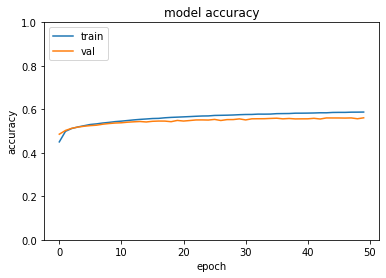

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylim(bottom=0, top=1.0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

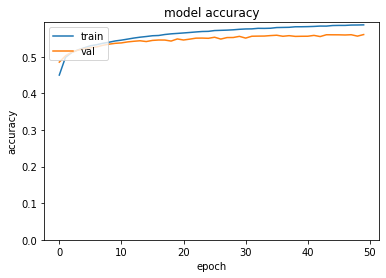

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

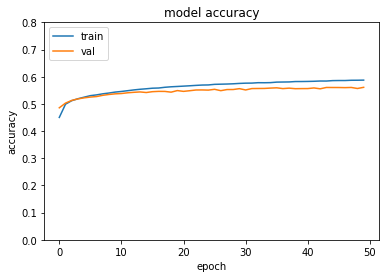

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylim(bottom=0,top=0.8)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
model.save('CS598RK_model_v5_cnn_0')
# model = keras.models.load_model('CS598RK_model_v2')

INFO:tensorflow:Assets written to: CS598RK_model_v5_cnn_0/assets


In [30]:
#Try to perform predictions
Y_pred_sampled = model.predict(Xtest_sampled) #prob. dist. showing likelihood of each class
predictions_sampled = np.argmax(Y_pred_sampled, axis = 1) #index of class with highest likelihood

In [33]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Ytest_sampled.argmax(axis=1), Y_pred_sampled.argmax(axis=1)))

ACCURACY OF THE MODEL:  0.5609887157442235


In [31]:
label_predict = {}
for idx in predictions_sampled:
    if idx in label_predict:
        label_predict[idx] += 1
    else:
        label_predict[idx] = 1

print(label_predict)

{8: 27148, 1: 6156, 6: 23966, 7: 1550, 9: 2593}


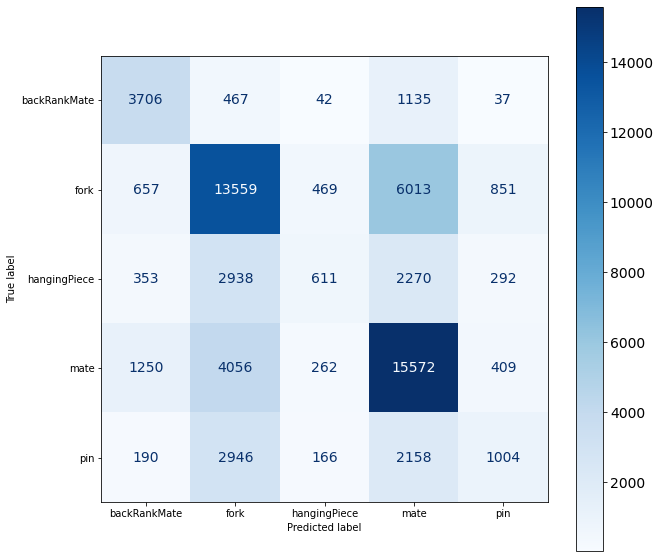

In [32]:
labels = [k for k in sizeDict_test.keys() if sizeDict_test[k]!=0]
cm = metrics.confusion_matrix(Ytest_sampled.argmax(axis=1), Y_pred_sampled.argmax(axis=1))
cm_fig = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
cm_fig.plot(cmap=plt.cm.Blues,ax=ax)
# plt.tight_layout()
plt.show(1

Use original distribution: {6: 6119, 8: 8285, 2: 32, 3: 659, 1: 338}

Done:
Reduce categories
Data imbalance

Todo:
1. May retake a look at the categories, try to exclude those ambigeous categories
2. cross-validation
3. CNN
4. RNN